In [1]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False)

In [2]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [3]:
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).cuda()
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
# model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=True).cuda()
model = torch.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=True).cuda()
model.eval()

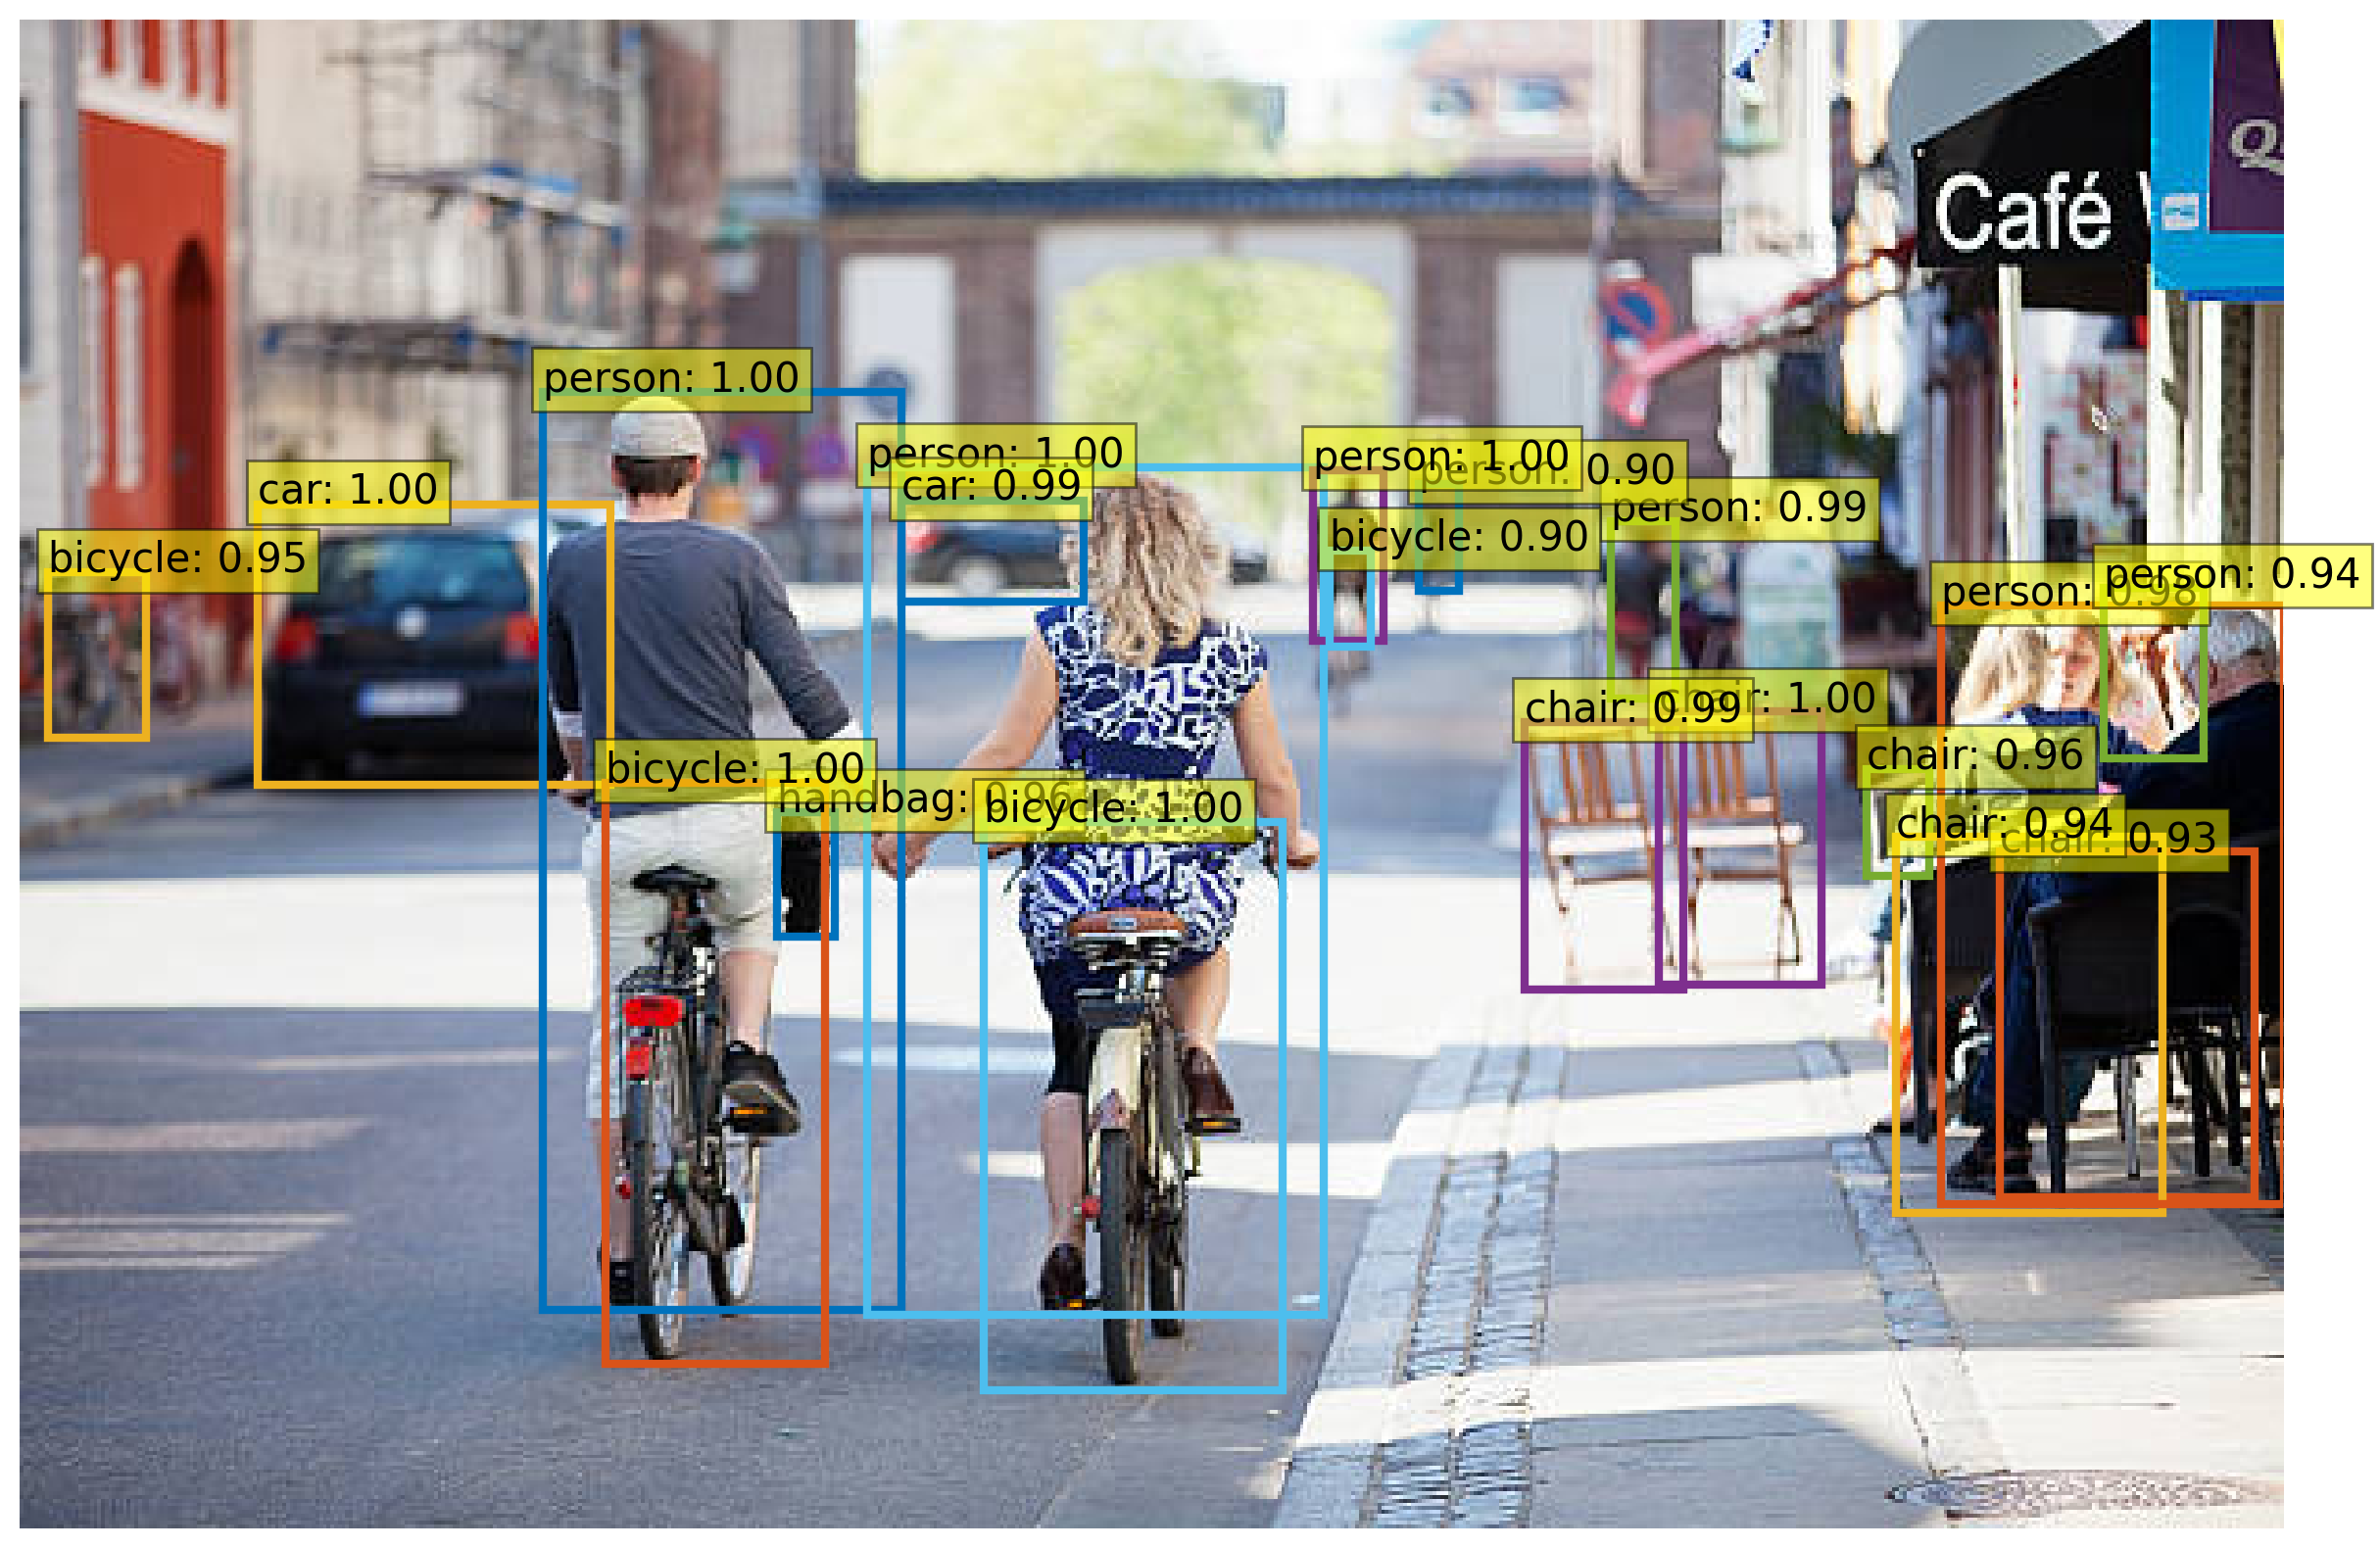

In [85]:
pil_image = Image.open("/workspace/images/bicycle.jpg")
image = transform(pil_image).unsqueeze(0).cuda()
image = (image - image.mean(dim=[2,3], keepdim=True)) / image.std(dim=[2,3], keepdim=True)
outputs = model(image)
probs = torch.nn.functional.softmax(outputs['pred_logits'], dim=-1)[0, :, :-1]
keep = torch.max(probs, dim=-1).values > 0.9
bbox = outputs['pred_boxes'][0, keep]
scaled_bbox = rescale_bboxes(bbox, pil_image.size)
plot_results(pil_image, probs[keep], scaled_bbox)

In [ ]:
model.transformer.encoder.layers[-1]

In [26]:
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks  = [
    model.backbone[-2].register_forward_hook (
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    )
]

outputs = model(image)
for hook in hooks:
    hook.remove()

In [62]:
conv_feature = conv_features[0]['0'].tensors.detach().cpu()
enc_attn_weight = enc_attn_weights[0].detach().cpu()
dec_attn_weight = dec_attn_weights[0].detach().cpu()

In [63]:
conv_feature.shape, enc_attn_weight.shape, dec_attn_weight.shape

(torch.Size([1, 2048, 25, 38]),
 torch.Size([1, 950, 950]),
 torch.Size([1, 100, 950]))

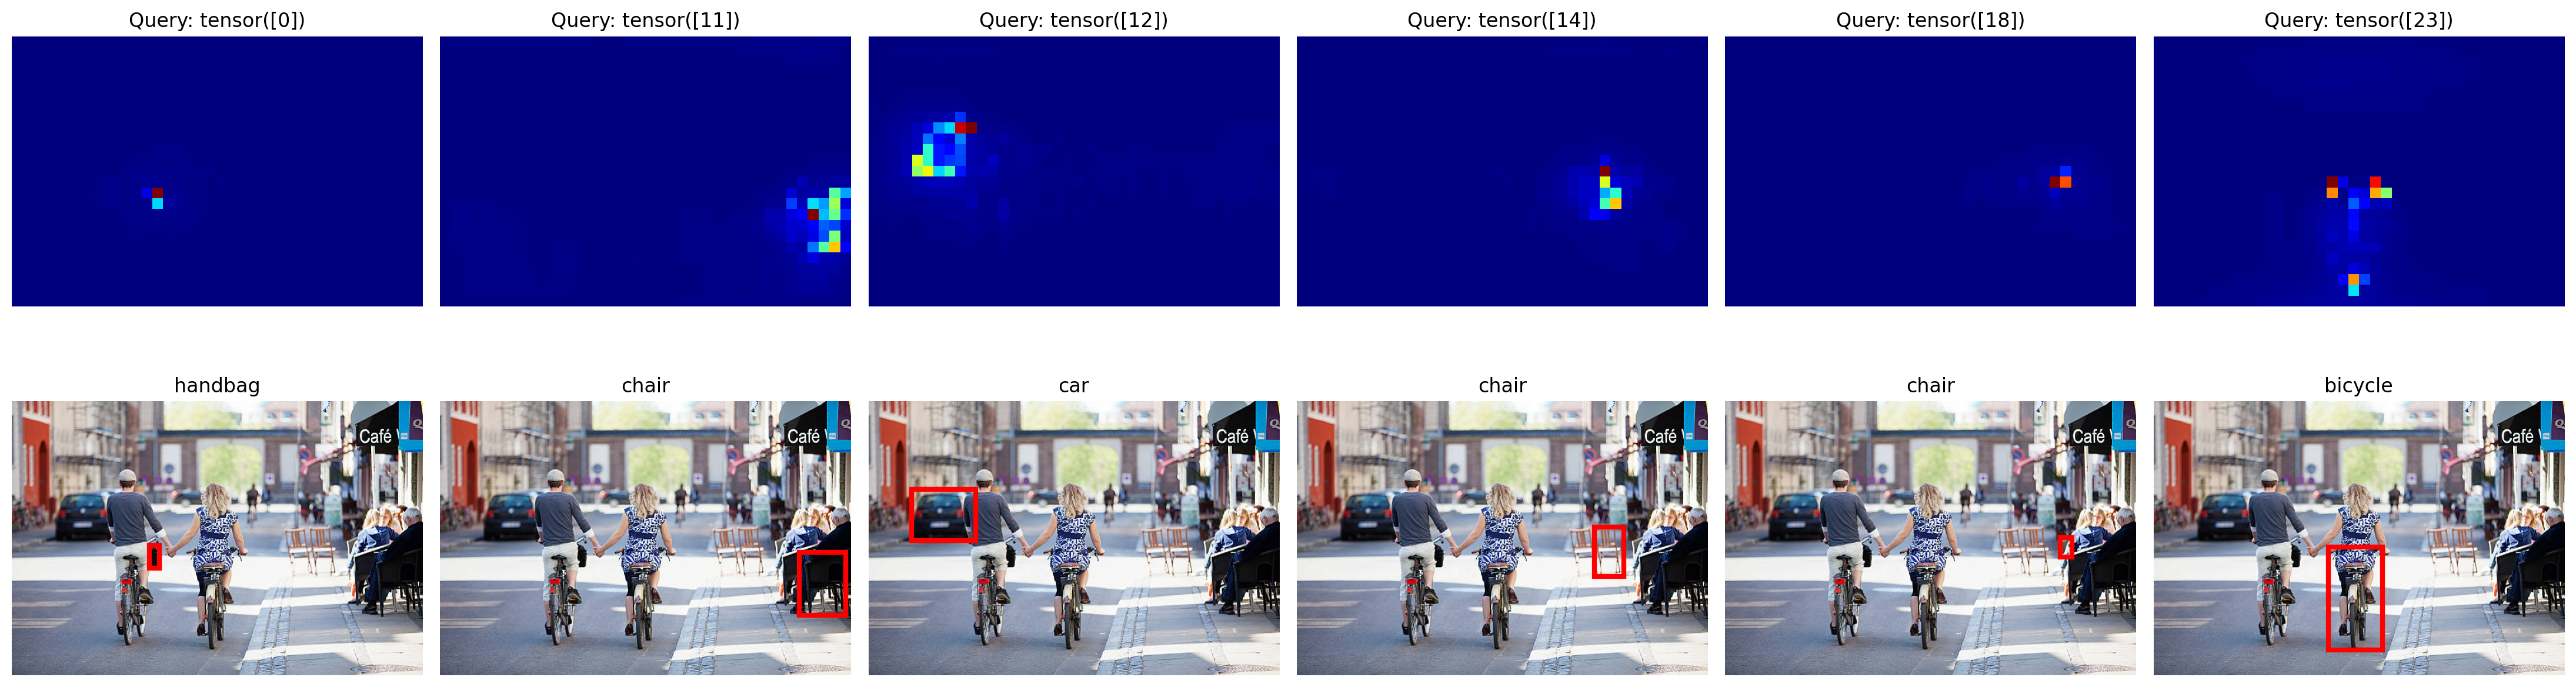

In [91]:
h, w = conv_feature.shape[-2:]

fig, axes = plt.subplots(ncols=6, nrows=2, figsize=(22,7))
colors = COLORS * 100
iter = 0

for index, axis, (x1, y1, x2, y2) in zip(keep.detach().cpu().nonzero(), axes.T, scaled_bbox.detach().cpu()):
    if iter == 6:
        break
    axs = axis[0]
    axs.imshow(dec_attn_weight[0, index].view(h, w), cmap='jet')
    axs.axis('off')
    axs.set_title(f'Query: {index}')

    axs = axis[1]
    axs.imshow(pil_image)
    axs.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=3))
    axs.axis('off')
    axs.set_title(f'{CLASSES[probs[index].argmax()]}')

fig.tight_layout()

In [90]:
shape = conv_feature.shape[-2:]
enc_attn_weight = enc_attn_weight.reshape(shape + shape)
enc_attn_weight.shape

torch.Size([25, 38, 25, 38])

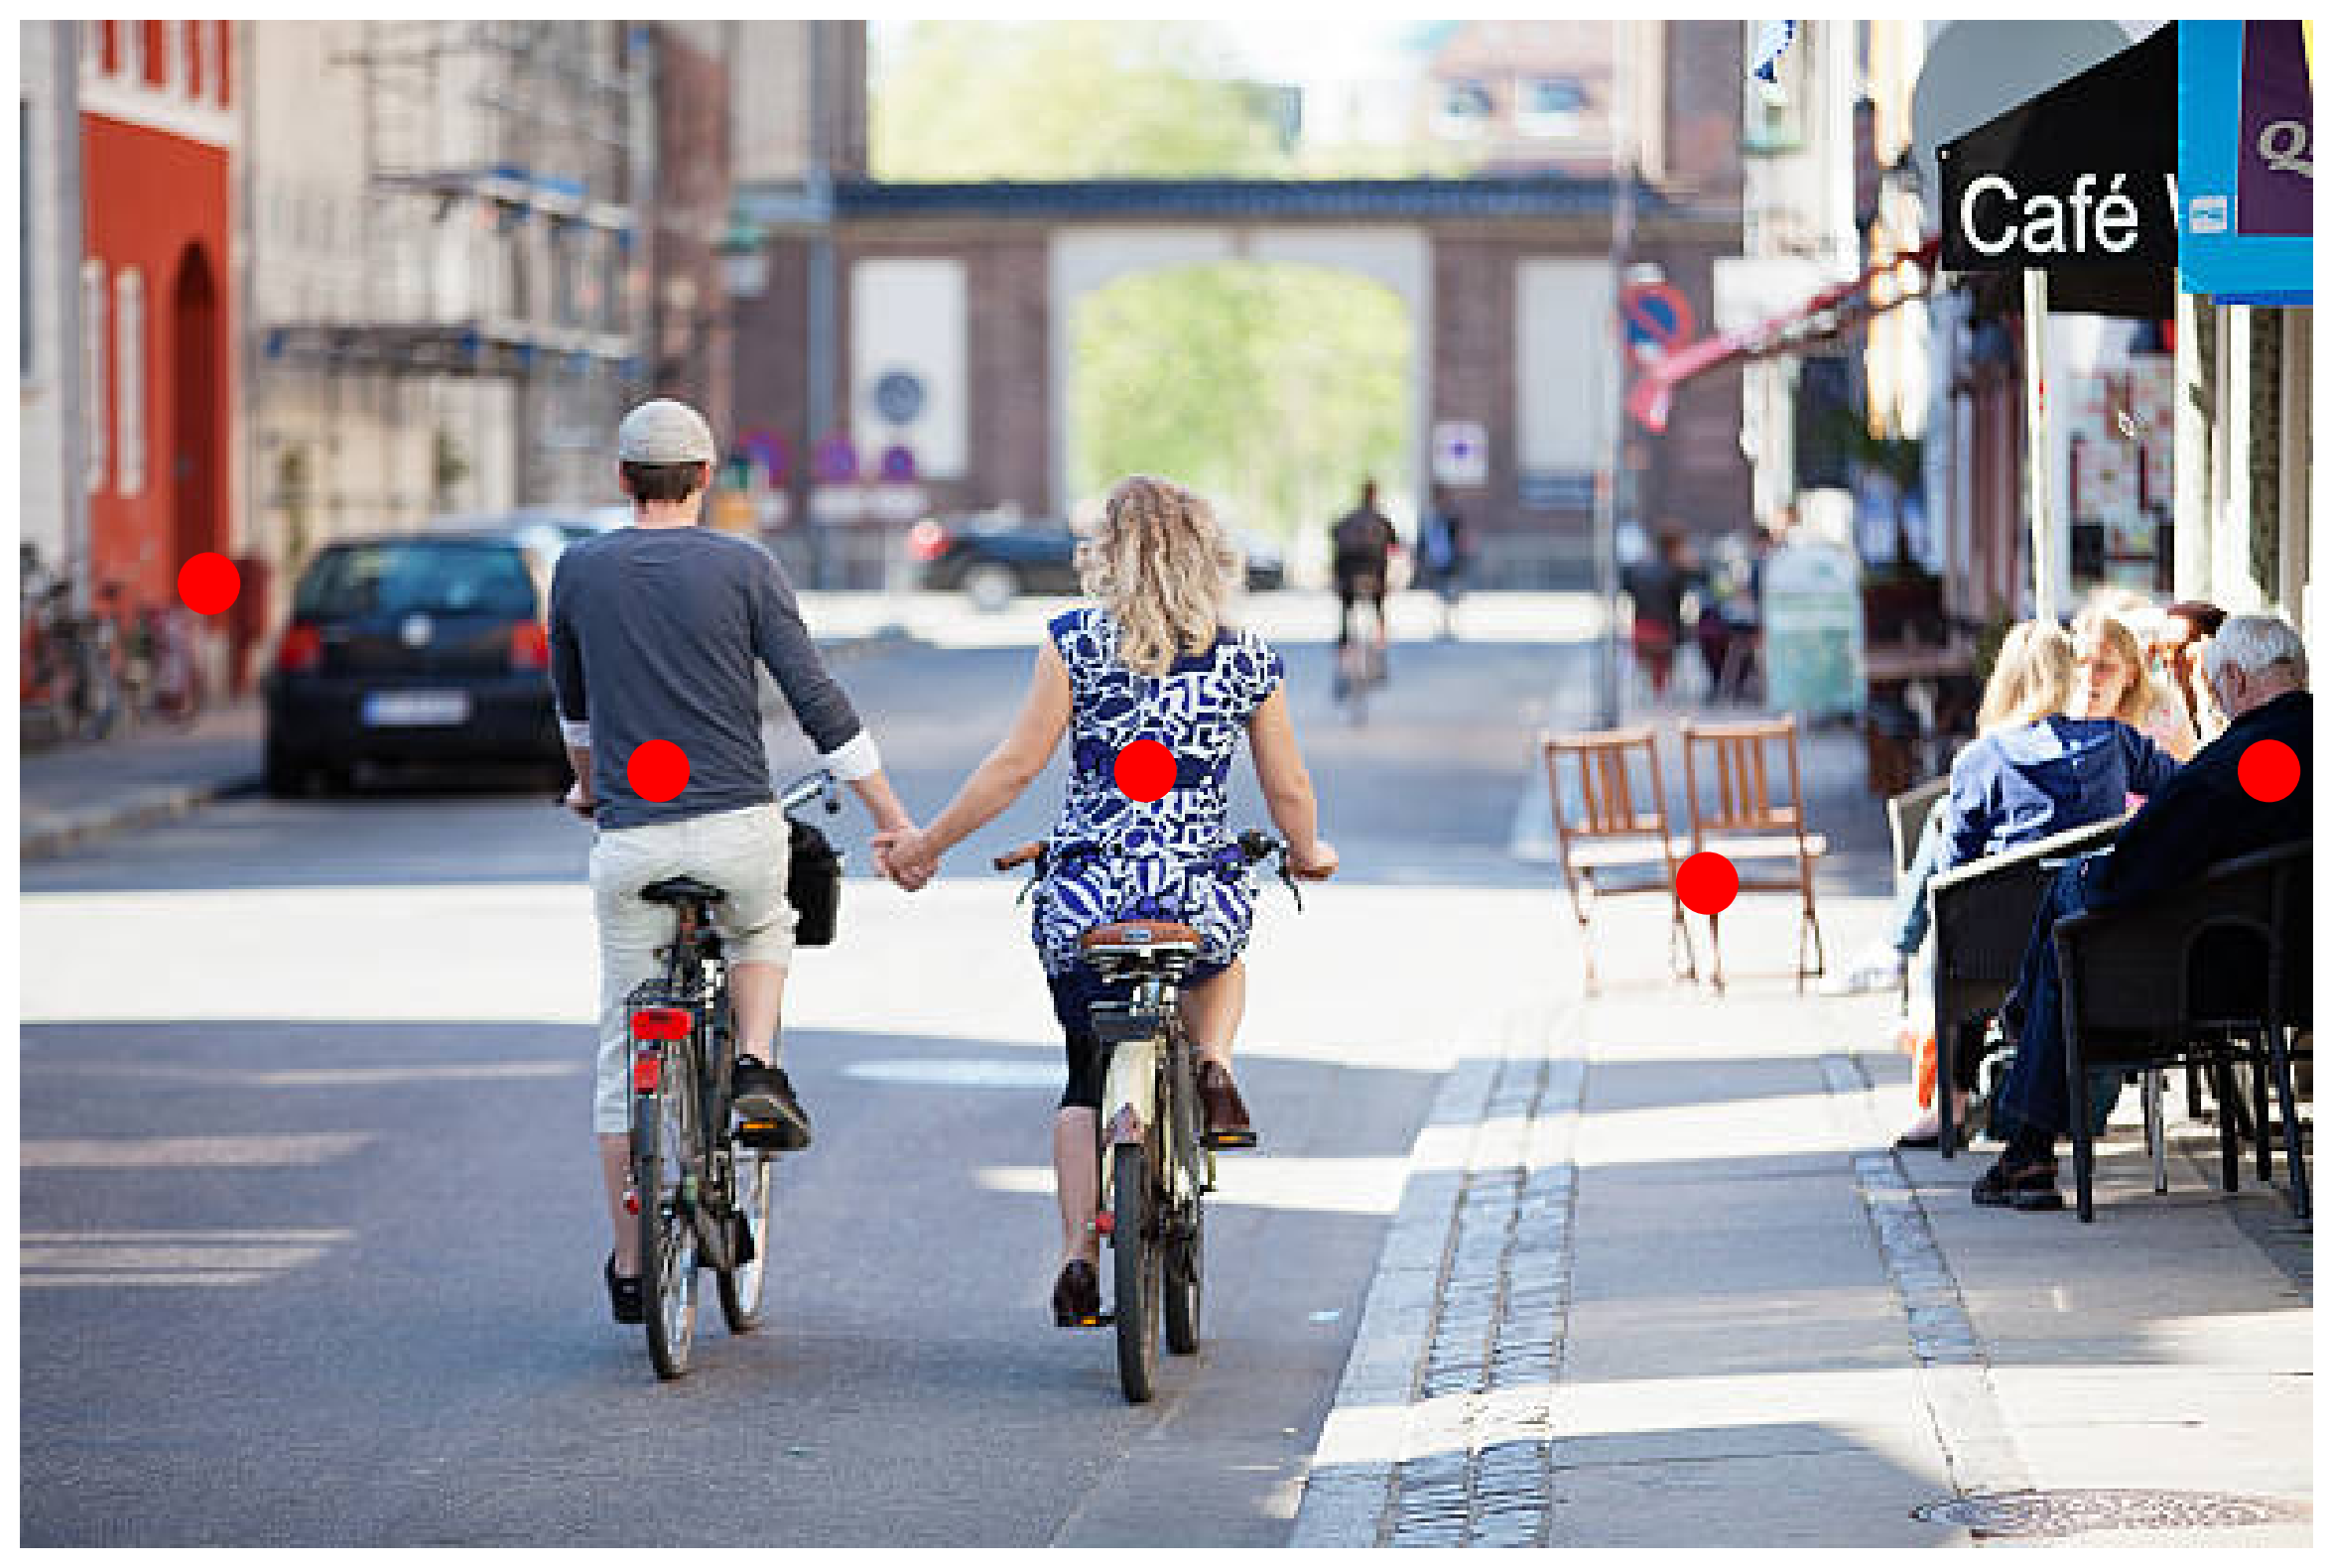

In [190]:
factor = 32
points = [(150, 50), (200, 170), (200, 300), (200, 600), (230, 450)]

plt.figure(figsize=(16,10))
plt.imshow(pil_image)
ax = plt.gca()

for (y, x) in points:
    scale = pil_image.height / image.shape[-2]
    ax.add_patch(plt.Circle((x, y), factor // 4, color='red'))
    ax.axis('off')

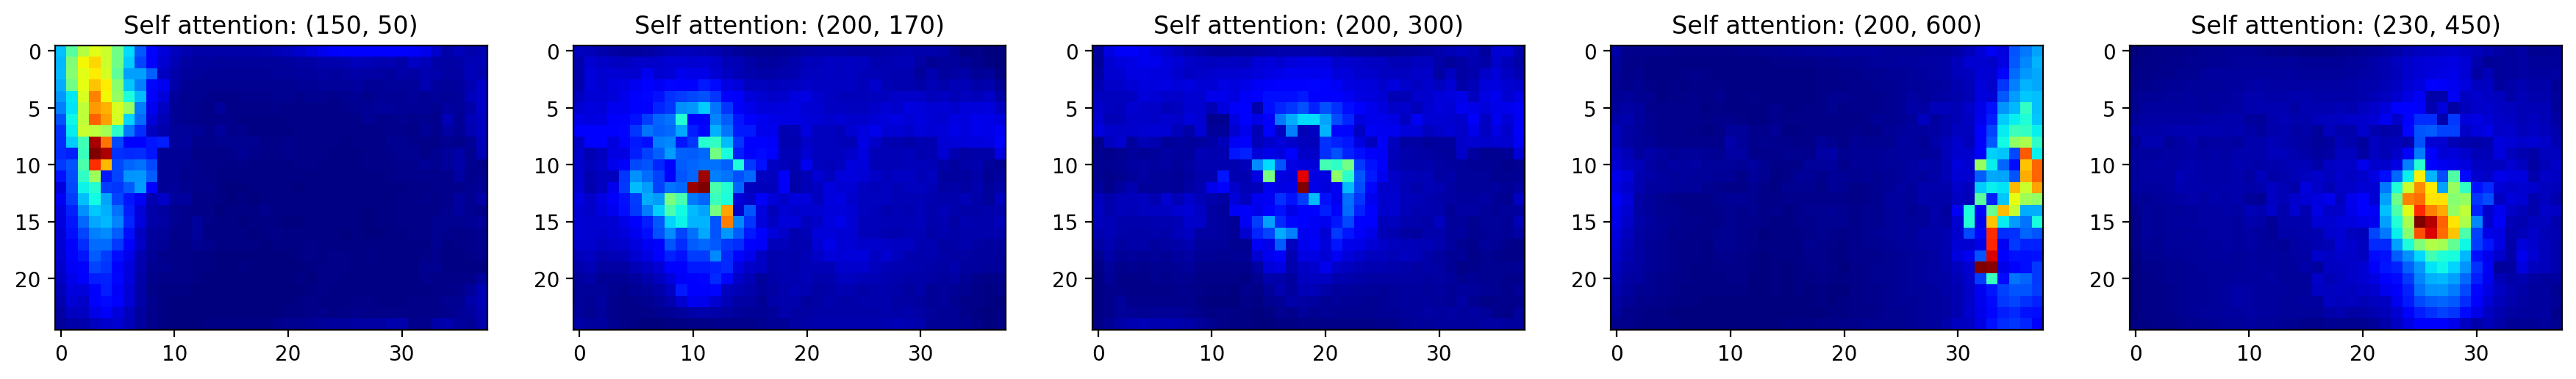

In [191]:
scale = image.shape[-1] / pil_image.size[0]
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,7))
for point, ax in zip(points, axes):
    pts = (int(point[0] * scale // factor), int(point[1] * scale // factor))
    ax.imshow(enc_attn_weight[..., pts[0], pts[1]], cmap='jet', interpolation='nearest')
    ax.set_title(f"Self attention: {point}")